In [38]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from gensim.models import Word2Vec
import gensim.downloader as api
from pymorphy3 import MorphAnalyzer

from utils import calc_metrics

In [2]:
X = pd.read_csv('data/x.csv', index_col='date')
y = pd.read_csv('data/y.csv', index_col='date').iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

### Word2Vec плюс линейная модель

Обучим `Word2Vec` на текстах наших данных, а представлением текста релиза будем считать сумму, представлений всех его слов.

In [28]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

In [4]:

texts = X.release.map(preprocessor).str.split()

best_models = {'window': [], 'roc_auc': [], 'model': []}
for window in tqdm(range(3, 20, 2)):
    model = Word2Vec(
        sentences=texts, 
        window=window,
        min_count=10, 
        vector_size=92,
        sg=1,
        epochs=100
        )

    embedings = texts.map(lambda x: [model.wv[word] for word in x if word in model.wv])
    embedings = embedings.map(lambda x: np.array(x).sum(0))
    embedings_w2v = np.array([arr.tolist() for arr in embedings])

    roc_auc, best_model = calc_metrics(
            embedings_w2v, y,
            LogisticRegression,
            name='embedings_w2v', 
            plot=False, 
            solver='saga', 
            penalty='elasticnet', 
            max_iter=10000, 
            # n_jobs=-1,
            l1_ratio=0.5
        )
        
    best_models['window'].append(window)
    best_models['roc_auc'].append(roc_auc)
    best_models['model'].append(best_model)

100%|██████████| 9/9 [07:50<00:00, 52.24s/it]


Посмотрим как меняется качество модели при изменении размера окна.

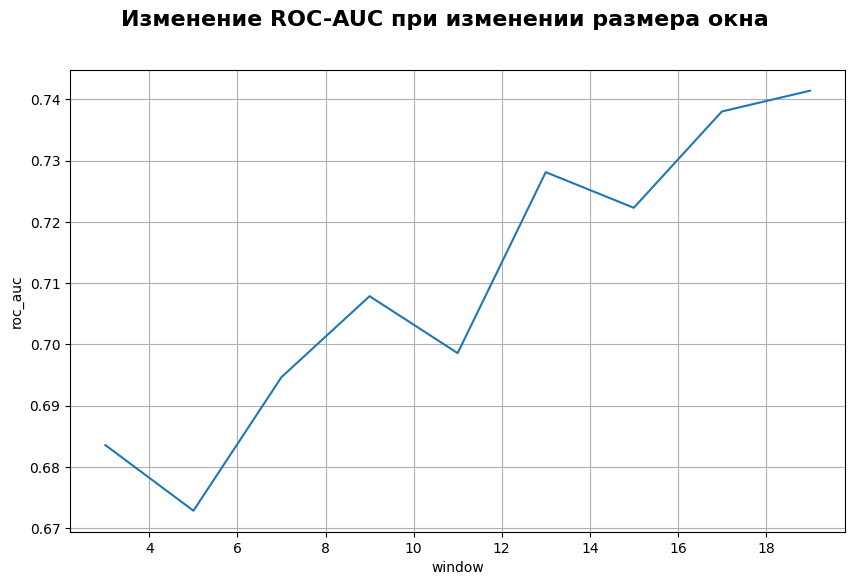

In [5]:
plt.figure(figsize=(10, 6))
data = pd.DataFrame(best_models)
sns.lineplot(x='window', y='roc_auc', data=data)
plt.suptitle("Изменение ROC-AUC при изменении размера окна", weight='bold', fontsize=16)
plt.grid()
plt.show()

При увеличении размера окна качество растет. Обучим Word2vec c размером окна 19 подберем оптимальные параметры логистической регрессии и оценим качество модели.

In [6]:
w2v = Word2Vec(
        sentences=texts, 
        window=15,
        min_count=10, 
        vector_size=92,
        sg=1,
        epochs=100
        )

embedings = texts.map(lambda x: [w2v.wv[word] for word in x if word in w2v.wv])
embedings = embedings.map(lambda x: np.array(x).sum(0))
embedings_w2v = np.array([arr.tolist() for arr in embedings])

auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(
                embedings_w2v, y,
                LogisticRegression,
                name='tf-idf', 
                plot=False, 
                solver='saga', 
                penalty='elasticnet', 
                C=c, 
                max_iter=10000, 
                # n_jobs=-1,
                l1_ratio=l1_ratio
            )
        )
    
roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

100%|██████████| 4/4 [06:21<00:00, 95.27s/it]

Лучшая модель - LogisticRegression(C=0.1, l1_ratio=0.9, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.744950123412977


Посмотрим на метрики модели подробнее

              precision    recall  f1-score   support

        -1.0       0.65      0.65      0.65        23
         0.0       0.48      0.46      0.47        24
         1.0       0.60      0.63      0.62        19

    accuracy                           0.58        66
   macro avg       0.58      0.58      0.58        66
weighted avg       0.57      0.58      0.57        66



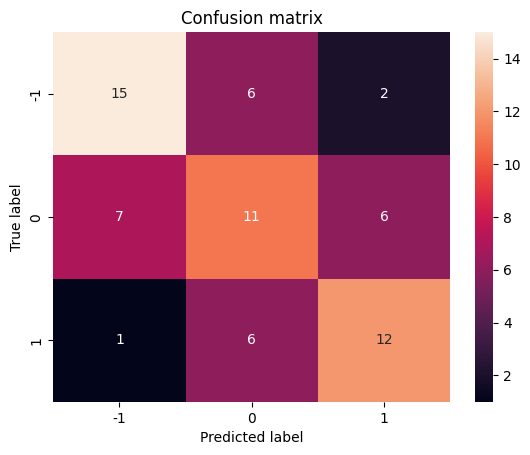

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.627058,0.642995,0.619311,0.769110
bow elasticnet,0.681818,0.686510,0.705556,0.678521,0.861207
bow release title,0.681818,0.686510,0.705556,0.678521,0.861207
bow release all num,0.696970,0.698591,0.708400,0.693618,0.858634
bow svc only release,0.666667,0.676367,0.695838,0.667684,0.836664
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901979
tf_idf title release,0.712121,0.717903,0.737500,0.709954,0.878747
tf_idf numerical release,0.681818,0.688457,0.731248,0.677314,0.835872


In [7]:
metric, model = calc_metrics(embedings_w2v, y, LogisticRegression, name='word2vec', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

Качество получили хуже чем минимальный бейзлайн, потому что `word2vec` неплохо создает представления слов, но в сумме этих представлений плохо сохраняется смысл всего текста. Попробуем уже обученную модель `word2vec`. Скачаем `word2vec-ruscorpora-300` обученную на русских текстах.

In [8]:
w2v_ruscorpora = api.load('word2vec-ruscorpora-300')

# функция для добавления части речи к словам
def tag(words):
    morph = MorphAnalyzer()
    parts = [str(morph.parse(word)[0].tag.POS) for word in words]
    return [word + '_' + part for word, part in zip(words, parts)]

In [9]:
embedings_ruscorpora = texts.map(tag).map(lambda x: [w2v_ruscorpora[word] for word in x if word in w2v_ruscorpora])
embedings_ruscorpora = embedings_ruscorpora.map(lambda x: np.array(x).sum(0))
embedings_ruscorpora = np.array([arr.tolist() for arr in embedings_ruscorpora])

In [10]:
auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(
                embedings_ruscorpora, y,
                LogisticRegression,
                name='pretrained_word2vec', 
                plot=False, 
                solver='saga', 
                penalty='elasticnet', 
                C=c, 
                max_iter=10000, 
                # n_jobs=-1,
                l1_ratio=l1_ratio
            )
        )
    
roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

100%|██████████| 4/4 [19:59<00:00, 299.85s/it]

Лучшая модель - LogisticRegression(C=0.1, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.7606292512727605


Оценим качество модели подробнее.

              precision    recall  f1-score   support

        -1.0       0.65      0.65      0.65        23
         0.0       0.45      0.54      0.49        24
         1.0       0.79      0.58      0.67        19

    accuracy                           0.59        66
   macro avg       0.63      0.59      0.60        66
weighted avg       0.62      0.59      0.60        66



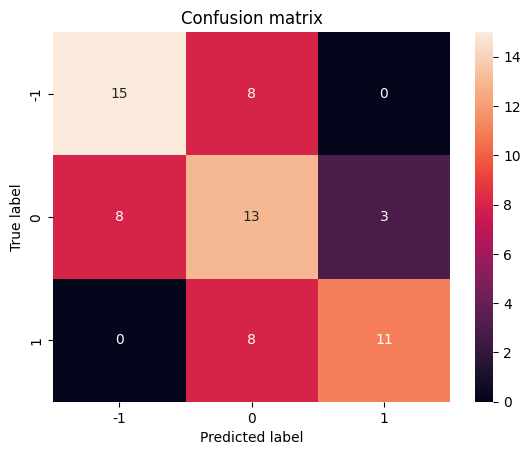

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.627058,0.642995,0.619311,0.769110
bow elasticnet,0.681818,0.686510,0.705556,0.678521,0.861207
bow release title,0.681818,0.686510,0.705556,0.678521,0.861207
bow release all num,0.696970,0.698591,0.708400,0.693618,0.858634
bow svc only release,0.666667,0.676367,0.695838,0.667684,0.836664
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901979
tf_idf title release,0.712121,0.717903,0.737500,0.709954,0.878747
tf_idf numerical release,0.681818,0.688457,0.731248,0.677314,0.835872


In [11]:
metric, model = calc_metrics(embedings_ruscorpora, y, LogisticRegression, name='word2vec_pretrained', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

Качество практически не изменилось по сравнению с прошлой моделью. Попробуем считать сумму ембедингов без слов, которые мы считали стоп словами в модели tf-idf.

In [29]:
with open('stopwords.txt', 'rt', encoding='utf-8') as file:
    STOP_WORDS |= set(s.strip() for s in file.readlines())

def tag(words):
    morph = MorphAnalyzer()
    parts = [str(morph.parse(word)[0].tag.POS) for word in words if word not in STOP_WORDS]
    return [word + '_' + part for word, part in zip(words, parts)]

In [31]:
embedings_ruscorpora_stop_words = texts.map(tag).map(lambda x: [w2v_ruscorpora[word] for word in x if word in w2v_ruscorpora])
embedings_ruscorpora_stop_words = embedings_ruscorpora_stop_words .map(lambda x: np.array(x).sum(0))
embedings_ruscorpora_stop_words  = np.array([arr.tolist() for arr in embedings_ruscorpora_stop_words])

In [36]:
auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(
                embedings_ruscorpora_stop_words, y,
                LogisticRegression,
                name='pretrained_word2vec', 
                plot=False, 
                solver='saga', 
                penalty='elasticnet', 
                C=c, 
                max_iter=10000, 
                # n_jobs=-1,
                l1_ratio=l1_ratio
            )
        )
    
roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 4/4 [11:57<00:00, 179.48s/it]

Лучшая модель - LogisticRegression(C=10, l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.6943267364305559


              precision    recall  f1-score   support

        -1.0       0.54      0.57      0.55        23
         0.0       0.35      0.38      0.36        24
         1.0       0.69      0.58      0.63        19

    accuracy                           0.50        66
   macro avg       0.53      0.51      0.51        66
weighted avg       0.51      0.50      0.50        66



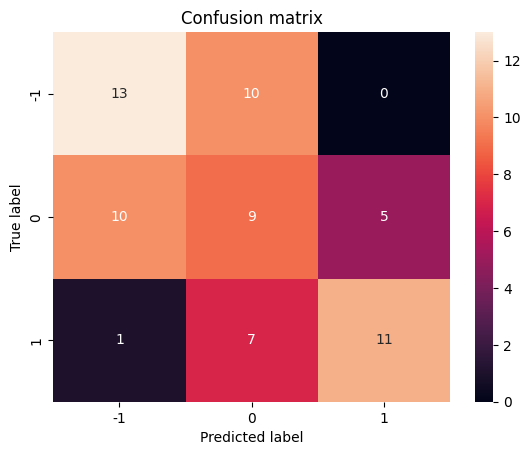

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.627058,0.642995,0.619311,0.769110
bow elasticnet,0.681818,0.686510,0.705556,0.678521,0.861207
bow release title,0.681818,0.686510,0.705556,0.678521,0.861207
bow release all num,0.696970,0.698591,0.708400,0.693618,0.858634
bow svc only release,0.666667,0.676367,0.695838,0.667684,0.836664
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901979
tf_idf title release,0.712121,0.717903,0.737500,0.709954,0.878747
tf_idf numerical release,0.681818,0.688457,0.731248,0.677314,0.835872


In [37]:
metric, model = calc_metrics(embedings_ruscorpora_stop_words, y, LogisticRegression, name='word2vec_pretrained_stop_words', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

Качество сильно хуже даже минимального бейзлайна. Попробуем обучить на word2vec_pretrained SVC.

In [39]:
auc = []
for c in tqdm([0.01, 0.05, 0.1, 0.5, 1, 3, 5, 7, 10]):
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        auc.append(
            calc_metrics(
                embedings_ruscorpora, y,
                SVC,
                name='bow svc only release', 
                kernel=kernel,
                C=c,
                plot=False, 
                probability=True,
                )
            )
    
roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

  0%|          | 0/9 [00:00<?, ?it/s]c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to con

Лучшая модель - SVC(C=0.5, kernel='linear', probability=True)
ROC-AUC = 0.7623060930406175


              precision    recall  f1-score   support

        -1.0       0.61      0.61      0.61        23
         0.0       0.42      0.42      0.42        24
         1.0       0.68      0.68      0.68        19

    accuracy                           0.56        66
   macro avg       0.57      0.57      0.57        66
weighted avg       0.56      0.56      0.56        66



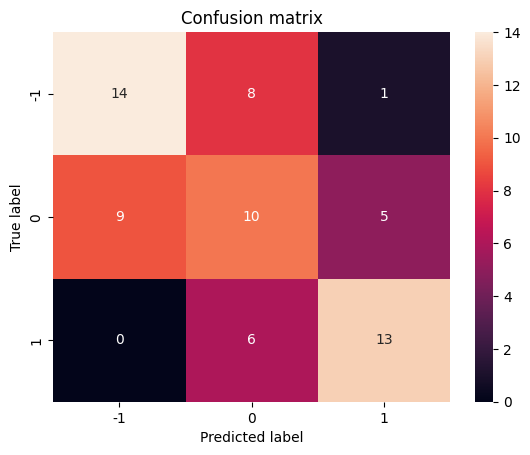

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.627058,0.642995,0.619311,0.769110
bow elasticnet,0.681818,0.686510,0.705556,0.678521,0.861207
bow release title,0.681818,0.686510,0.705556,0.678521,0.861207
bow release all num,0.696970,0.698591,0.708400,0.693618,0.858634
bow svc only release,0.666667,0.676367,0.695838,0.667684,0.836664
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901979
tf_idf title release,0.712121,0.717903,0.737500,0.709954,0.878747
tf_idf numerical release,0.681818,0.688457,0.731248,0.677314,0.835872


In [40]:
metric, _ = calc_metrics(
    embedings_ruscorpora, y, 
    SVC, 
    name='word2vec_pretrained svc', 
    **best_model.get_params()
    )

metrics = pd.concat([metrics, metric])
metrics

Качество получилось хуже чем линейная регрессия. Сохраним результаты экпериментов.

In [41]:
metrics.to_csv('metrics.csv')